### BUILDING MICROGRAD
##### INTRO TO NEURAL NETS

In [1]:
# MICROGRAD - AUTO GRADIENT ENGINE (MICRO GRADIENT ENGINE)
# Implements Backpropagation

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x +5

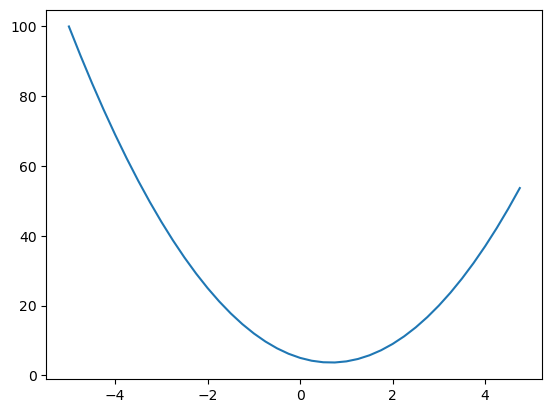

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
### DERIVATIVE = RATE AT WHICH Y INCREASES WITH X

In [6]:
h=0.001
x=3
(f(x+h)-f(x))/h

14.00300000000243

In [7]:
a = 2
b = -3
c = 10
d = a*b+c
print(d)

4


In [8]:
h=0.0001
b = -3
c = 10
d1 = a*b+c
a += h 
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4
d2 3.999699999999999
slope -3.000000000010772


In [9]:
h=0.0001
b = -3
c = 10
d1 = a*b+c
b += h 
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947


In [10]:
h=0.0001
b = -3
c = 10
d1 = a*b+c
c += h 
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 3.999699999999999
d2 3.9997999999999987
slope 0.9999999999976694


In [11]:
class Value:
    def __init__(self,data,_children = (), _op = '',label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),'+')
        
        def _backward():
            self.grad = 1.0*out.grad
            other.grad = 1.0*out.grad
            
        out._backward = _backward
            
        return out
        
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [13]:
a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10.0,label = 'c')
e = a * b; e.label = 'e' 
d= e + c; d.label = 'd'
f = Value(-2.0,label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

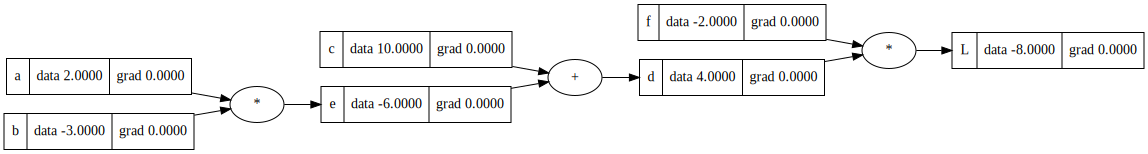

In [14]:
draw_dot(L)

### BACK PROPOGATE THROUGH NEURONS

In [15]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

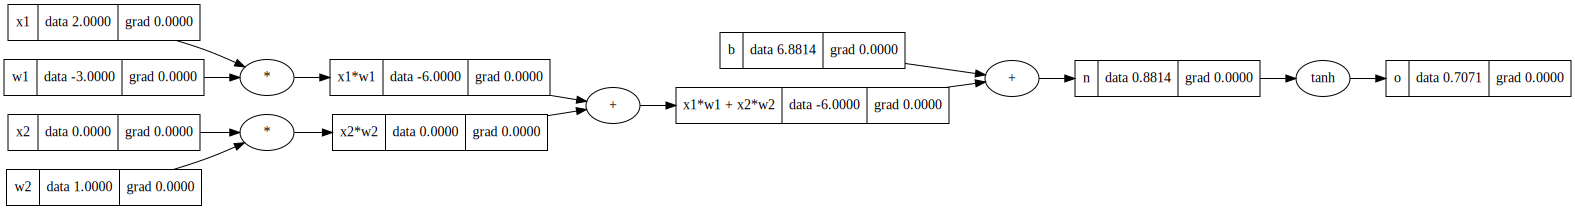

In [16]:
draw_dot(o)

In [17]:
o.grad = 1.0

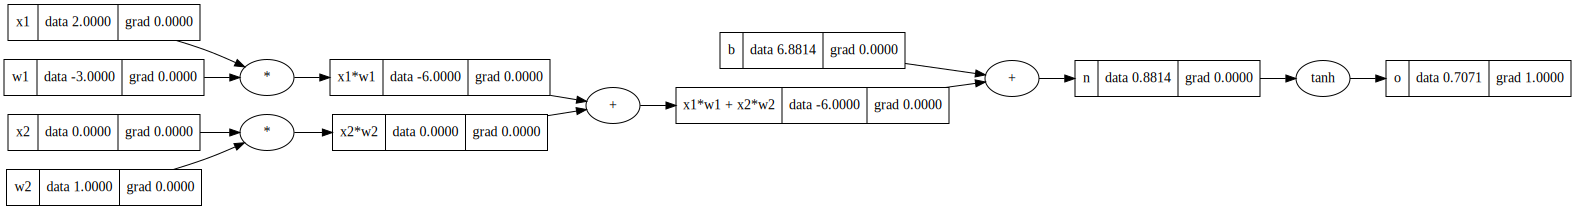

In [18]:
draw_dot(o)

In [19]:
o._backward()

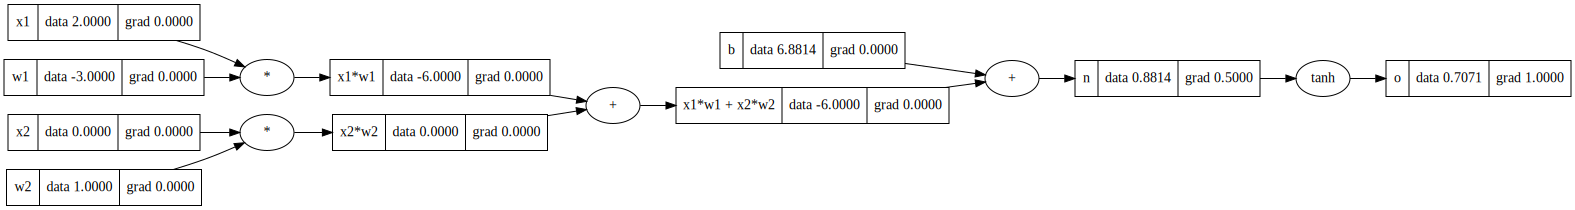

In [20]:
draw_dot(o)

In [21]:
n._backward()

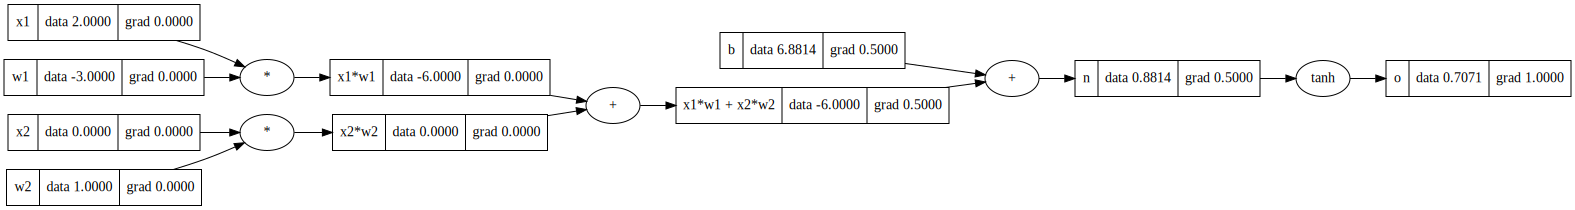

In [22]:
draw_dot(o)

In [23]:
b._backward()

In [24]:
x1w1x2w2._backward()

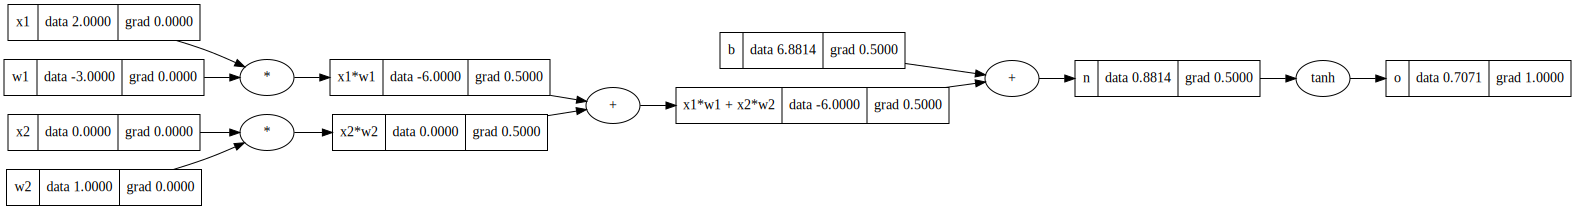

In [25]:
draw_dot(o)

In [26]:
x1w1._backward()
x2w2._backward()

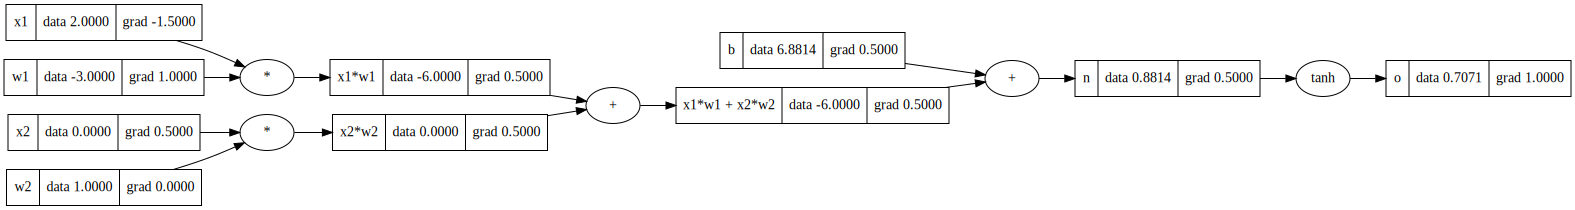

In [27]:
draw_dot(o)

In [28]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

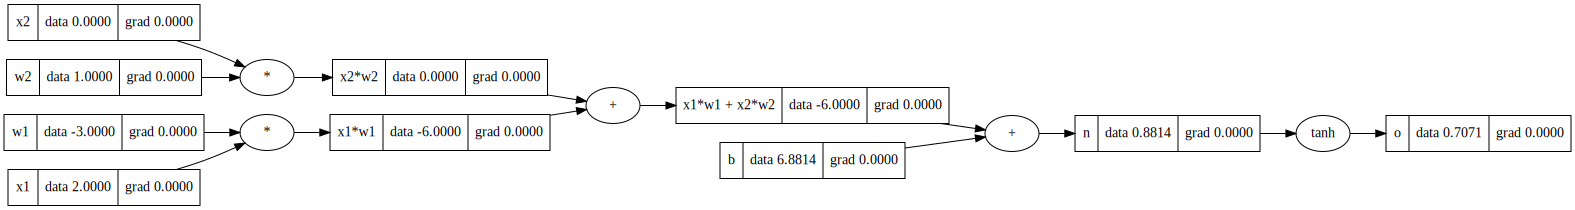

In [30]:
draw_dot(o)

In [ ]:
# this is the topological order for the graph that we can use to backpropagate

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

#gradient for this is going to be 1.0 as this is the final output node (self derivative)
o.grad = 1.0

#we are doing reverse back propagation here in the graph using chain rule
for node in reversed(topo):
    node._backward()

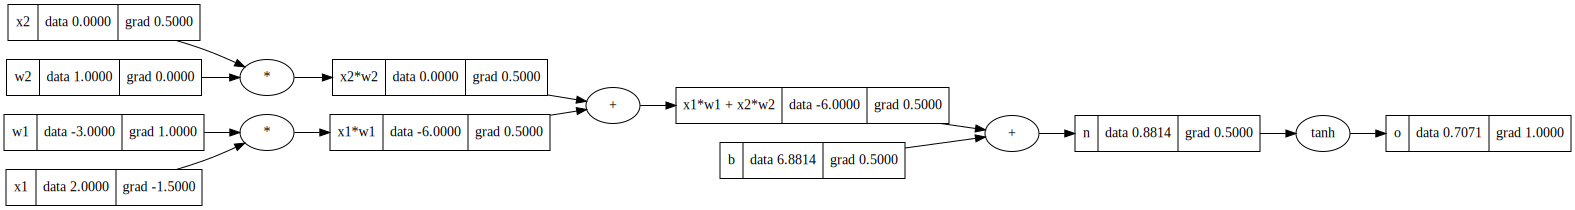

In [32]:
draw_dot(o)

### NEW VALUE CLASS

In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) #this is tanh(x)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad #this is d/dx tanh(x) which is 1 - tanh^2(x)
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [34]:
a = Value(2.0)
b = Value(4.0)

a-b

Value(data=-2.0)

### BREAKING THE GRAPH

In [35]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [36]:
o.backward()

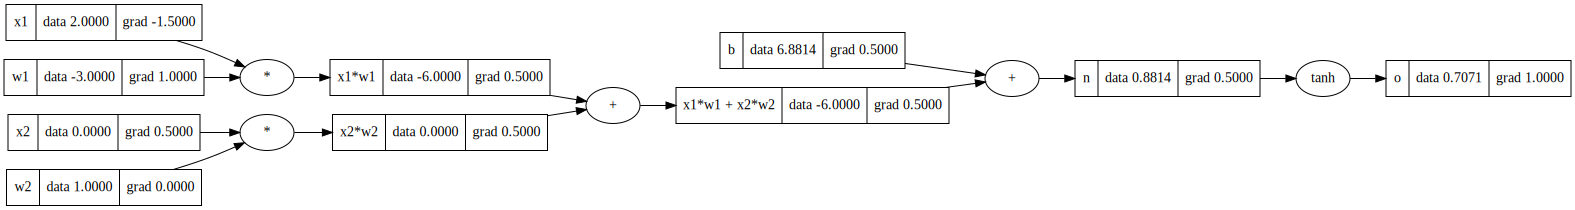

In [37]:
draw_dot(o)

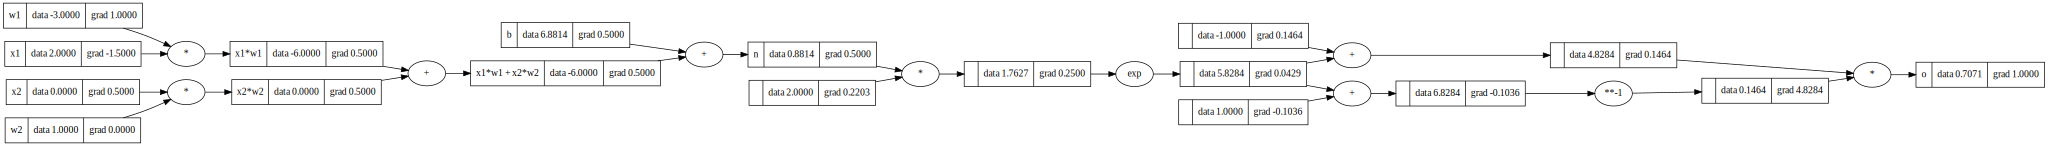

In [38]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

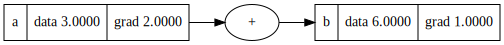

In [39]:
 a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

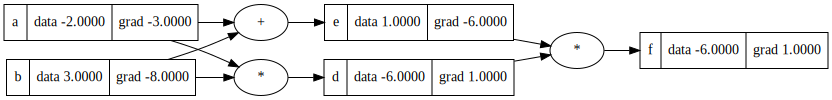

In [40]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

---------

In [41]:
### PYTORCH INTRO

In [42]:
import torch

In [43]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [44]:
import random

In [45]:
class Neuron:
  
  def __init__(self, nin):
    # nin = number of inputs to a neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

In [46]:
x = [2.0, 3.0]
n = Neuron(2)

n(x)

Value(data=0.5208378970232831)

In [47]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


In [48]:
x = [2.0, 3.0]
n = Layer(2,3)

n(x)

[Value(data=0.41843144739898747),
 Value(data=-0.9982160974532224),
 Value(data=0.08043392908188096)]

In [49]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [50]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.6279262992568853)

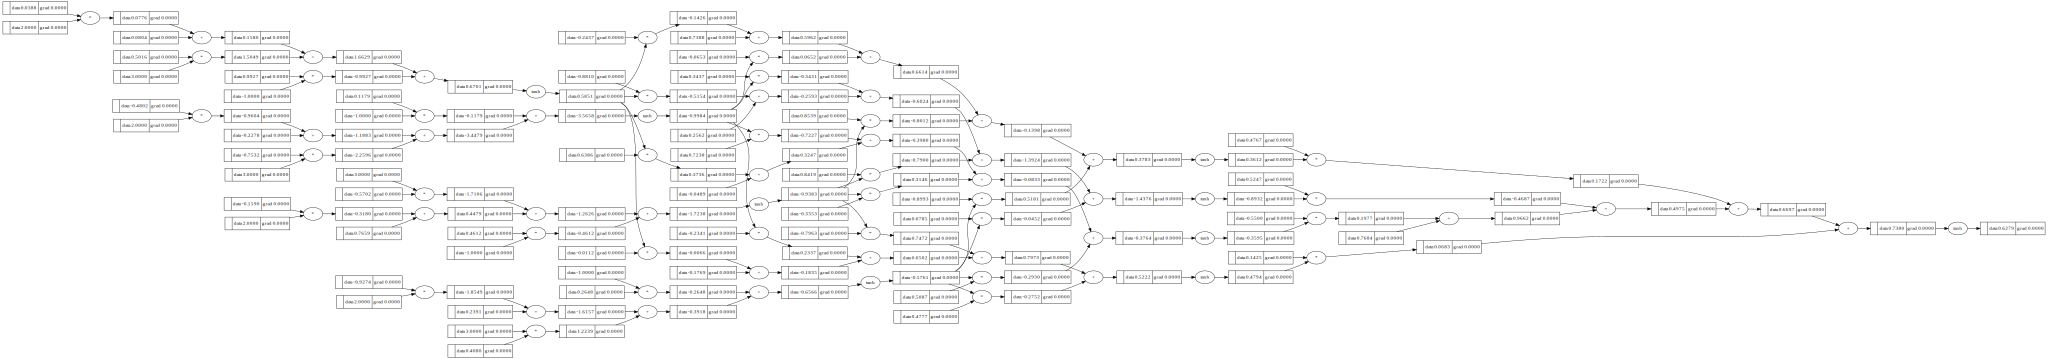

In [51]:
draw_dot(n(x))

In [52]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.6279262992568853),
 Value(data=0.9466138175610348),
 Value(data=0.6782949083690757),
 Value(data=0.9078194177623007)]

In [53]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.752915252703469)

In [54]:
loss.backward()

In [55]:
n.layers[0].neurons[0].w[0].grad

-0.3779673450896406

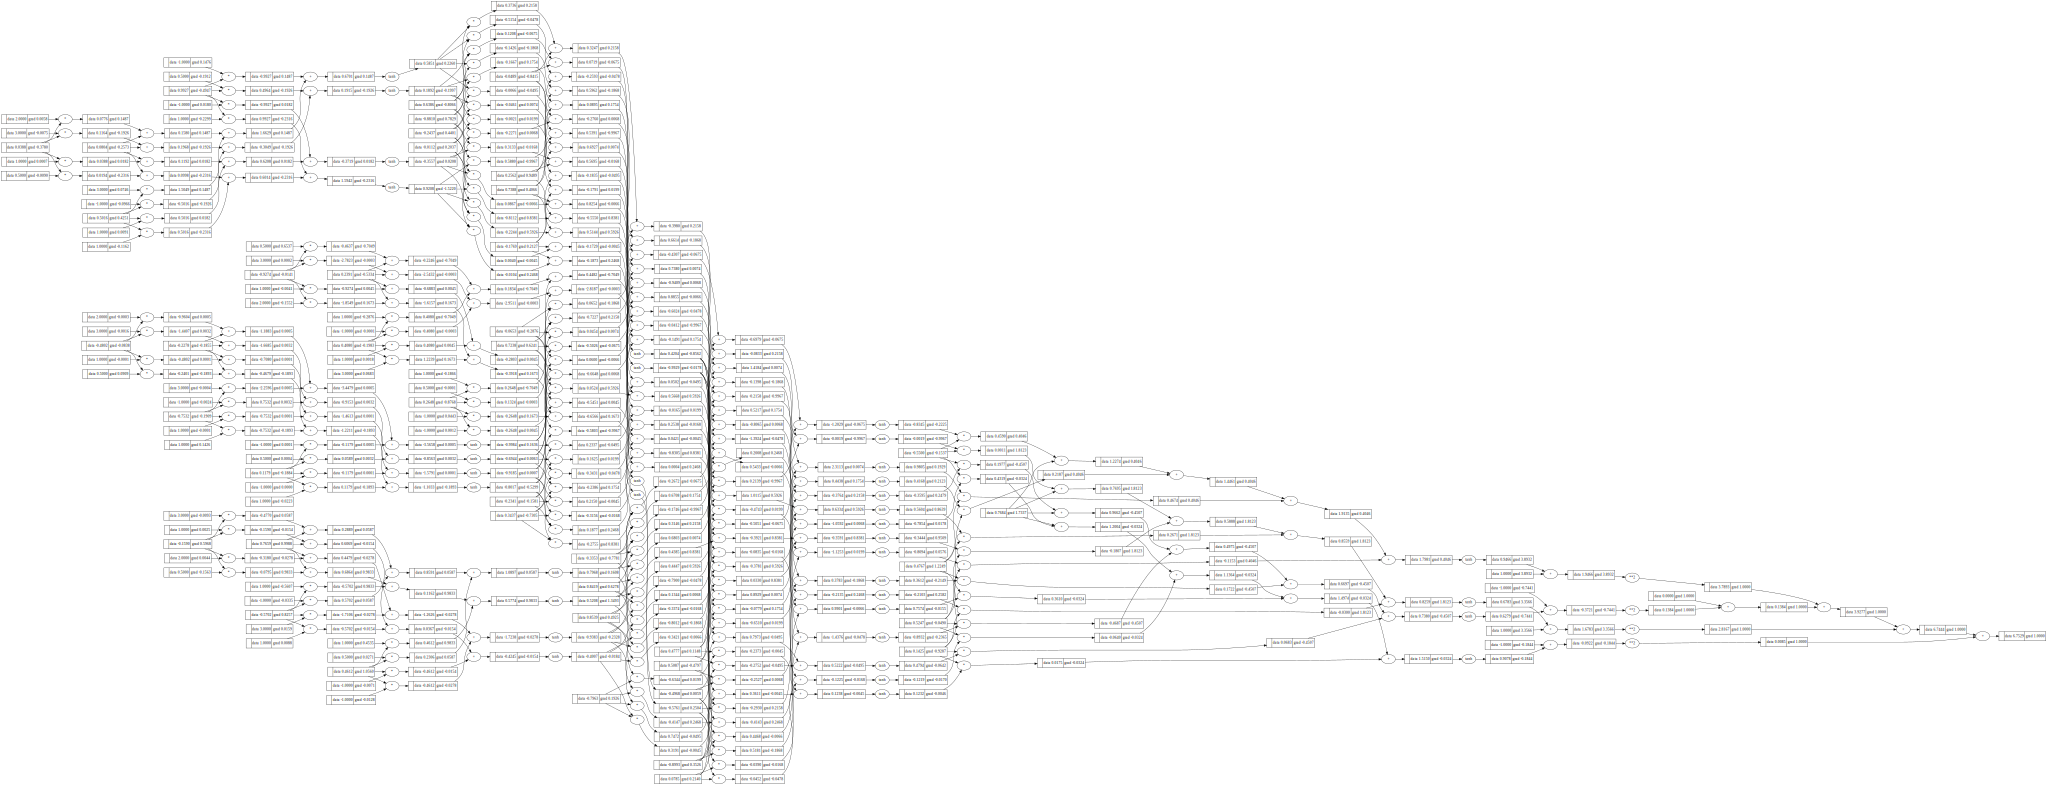

In [56]:
draw_dot(loss)

In [57]:
n.parameters()

[Value(data=0.038787428253785894),
 Value(data=0.5016349887154286),
 Value(data=0.9927328637954915),
 Value(data=0.08039567778559609),
 Value(data=-0.48021699588151745),
 Value(data=-0.7532164621504884),
 Value(data=0.11788908461821879),
 Value(data=-0.22782359195857405),
 Value(data=-0.15899621035248734),
 Value(data=-0.5701844926075845),
 Value(data=0.46120581766284197),
 Value(data=0.7659034155652844),
 Value(data=-0.9274341179043457),
 Value(data=0.40797962897206297),
 Value(data=0.2647884104902736),
 Value(data=0.23914005831157104),
 Value(data=0.6386034851166102),
 Value(data=0.7238274328819563),
 Value(data=-0.33531913469857755),
 Value(data=0.5086764127779164),
 Value(data=-0.04891222721886268),
 Value(data=-0.8809739864051522),
 Value(data=0.34366981497263405),
 Value(data=0.8419021717125712),
 Value(data=0.07845384414399836),
 Value(data=0.25615768131589745),
 Value(data=-0.2436728267473196),
 Value(data=-0.0653460937287138),
 Value(data=0.8538751460821759),
 Value(data=-0.89

In [58]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 6.752915252703469
1 4.752222766381108
2 1.89615175720443
3 0.4823710938086704
4 0.19491612963782975
5 0.12034592189159625
6 0.08642263986258657
7 0.0671047052263862
8 0.05467130384897197
9 0.04602063330630557
10 0.03966674454995989
11 0.0348095697451047
12 0.03098066959927057
13 0.02788783967075936
14 0.025339526656359183
15 0.023205027291483438
16 0.021392164680280747
17 0.01983410596104543
18 0.018481237134196325
19 0.017295969952997717


In [59]:
n.parameters()

[Value(data=0.20671711476709936),
 Value(data=-0.14743494356491713),
 Value(data=1.3705462258637842),
 Value(data=0.09470305142179922),
 Value(data=-0.25124286558580283),
 Value(data=-0.7567490937486756),
 Value(data=0.20952772068707498),
 Value(data=-0.09954891983099055),
 Value(data=-0.3640601549348646),
 Value(data=-0.6341748746794441),
 Value(data=0.2884312954229355),
 Value(data=0.5904836664462713),
 Value(data=-0.9794602781885805),
 Value(data=0.35754045996676415),
 Value(data=0.4839574342692475),
 Value(data=0.3279089163031608),
 Value(data=1.0393096862190998),
 Value(data=0.563744224055794),
 Value(data=-0.022258946568132557),
 Value(data=0.5022350484525869),
 Value(data=0.2909615076357049),
 Value(data=-1.2451627307302797),
 Value(data=0.4282878837394659),
 Value(data=0.5632105640370764),
 Value(data=0.052197578117711134),
 Value(data=0.06074050301646669),
 Value(data=-0.38585050778961644),
 Value(data=-0.014737661122997627),
 Value(data=0.7174955024380761),
 Value(data=-1.025